# Breast cancer clustering and classification with scikit-learn

This example uses the standard breast cancer dataset</a> from the UCI machine learning data repository. We train a k-nearest neighbors classifier using sci-kit learn and then explain the predictions.

In [268]:
import sklearn
import shap
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

from sklearn.datasets import load_breast_cancer


shap.initjs()

## Load the census data

In [299]:
# X,y = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)

X,y = load_breast_cancer(return_X_y=True)

data = load_breast_cancer()
X = pd.DataFrame(data=X)


In [300]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=7)

## Normalize the data before training the model

In [301]:
# normalize data
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s
    
    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

print(X_train.shape)

(455, 30)


# Visualize Data using the original labels

## Embed using t-SNE

In [302]:
def plot_samples(X_embedded, y_train, cluster_num):
    # define the colormap
    cmaplist = ['red', 'blue', 'green', 'orange', 'gray', 'purple', 'black', 'yellow', 'pink']

    
    color= [cmaplist[int(l) % cluster_num] for l in y_train]
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color, s=3)

    plt.xlabel('x')
    plt.ylabel('y')

cluster_num = 2
X_embedded = TSNE(n_components=cluster_num).fit_transform(X_train)
print(X_embedded.shape)


(455, 2)


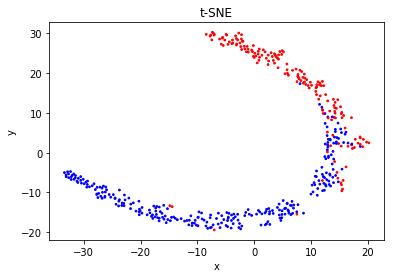

In [305]:
plot_samples(X_embedded, y_train, 2)
plt.title('t-SNE')
plt.show()

# K-Clustering

In [306]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

print(np.sum(pca.explained_variance_ratio_))

kmeans = KMeans(n_clusters=2, random_state=7).fit(X_train_pca)
y_train_pred = kmeans.predict(X_train_pca)
print(np.sum(kmeans.labels_))

0.9997890912390763
111


# Visualize Data using the clustering labels

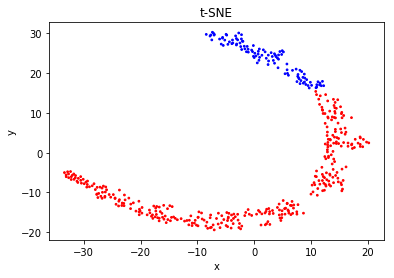

In [307]:
plot_samples(X_embedded, y_train_pred, 2)
plt.title('t-SNE')
plt.show()

# Explain using the Clustering Label

## Train a k-nearest neighbors classifier


In [326]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train_pca, y_train_pred)
f = lambda x: knn.predict_proba(pca.transform(x))[:,1]

### Explain predictions

Normally we would use a logit link function to allow the additive feature inputs to better map to the model's probabilistic output space, but knn's can produce infinite log odds ratios so we don't for this example.

It is important to note that 23(worst area) is the dominant feature in the 1000 predictions we explain. This is because it has larger variations in value than the other features and so it impacts the k-nearest neighbors calculations more.

In [340]:
# med = X_train.median().values.reshape((1,X_train.shape[1]))
# mean = X_train.mean()[None,:]
# print(type(med), type(mean))
X_rep = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(f, X_rep)
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(shap_values_single, X_train)

In [341]:
shap_values = explainer.shap_values(X_valid.iloc[:,:], nsamples=1000)
shap.force_plot(shap_values, X_valid.iloc[:,:])


100%|██████████| 114/114 [01:04<00:00,  1.77it/s]


In [342]:
print(data.feature_names[23])
print(data.feature_names[3])
print(data.feature_names[13])

worst area
mean area
area error


A summary plot is an even better way to see the relative impact of all features over the entire dataset. Features are sorted by the sum of their SHAP value magnitudes across all samples.

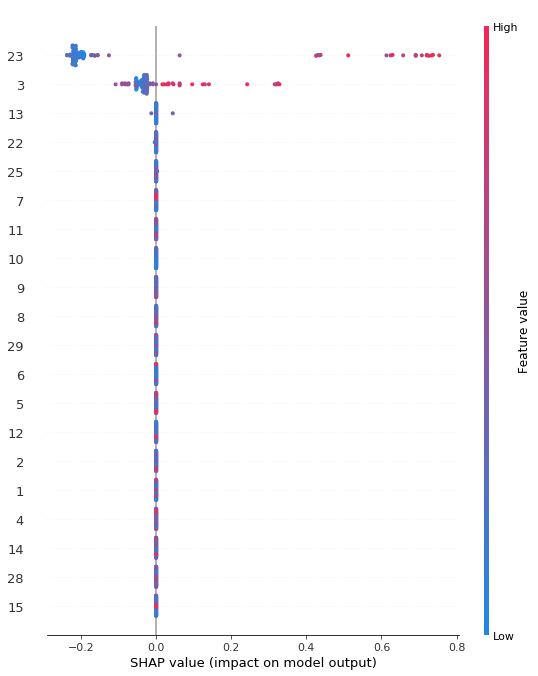

In [343]:
shap.summary_plot(shap_values, X_valid.iloc[:,:])

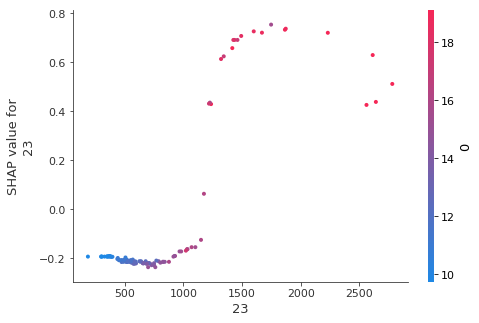

In [344]:
shap.dependence_plot(23, shap_values, X_valid.iloc[:,:])

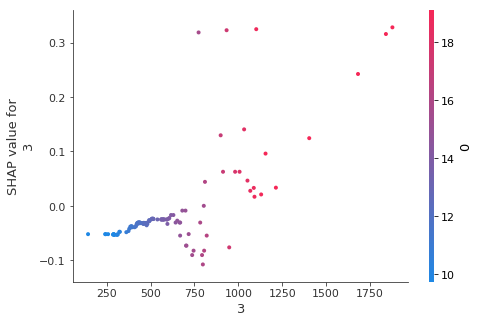

In [345]:
shap.dependence_plot(3, shap_values, X_valid.iloc[:,:])

# Explain using the Original Label

In [346]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
f_original = lambda x: knn.predict_proba(x)[:,1]

In [347]:
# med = X_train.median().values.reshape((1,X_train.shape[1]))

X_rep = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(f_original, X_rep)
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(shap_values_single, X_train)

In [348]:
shap_values_original = explainer.shap_values(X_valid.iloc[:,:], nsamples=1000)
shap.force_plot(shap_values_original, X_valid.iloc[:,:])


100%|██████████| 114/114 [01:09<00:00,  1.63it/s]


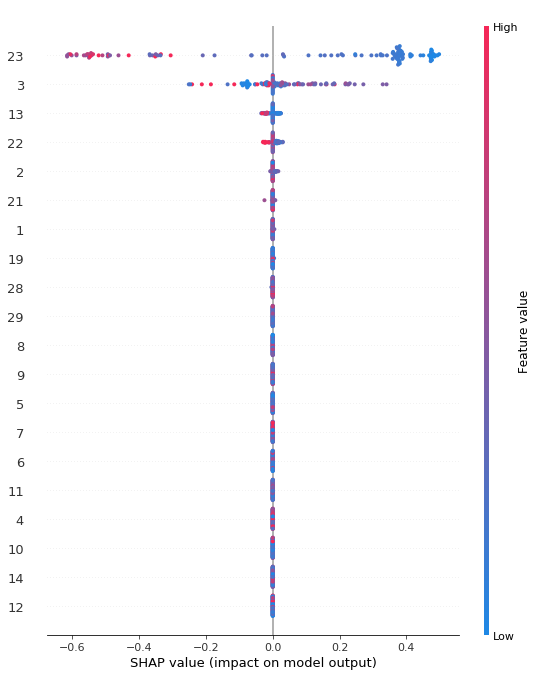

In [349]:
shap.summary_plot(shap_values_original, X_valid.iloc[:,:])

In [261]:
print(data.feature_names[23])
print(data.feature_names[3])
print(data.feature_names[22])
print(data.feature_names[2])
print(data.feature_names[13])
print(data.feature_names[21])

worst area
mean area
worst perimeter
mean perimeter
area error
worst texture


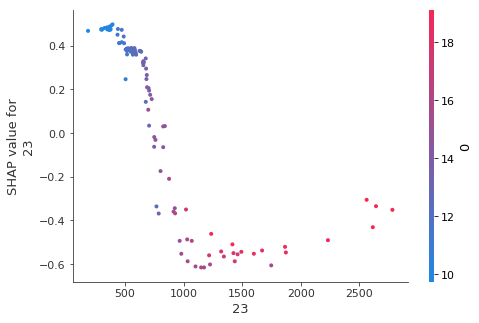

In [350]:
shap.dependence_plot(23, shap_values_original, X_valid.iloc[:,:])

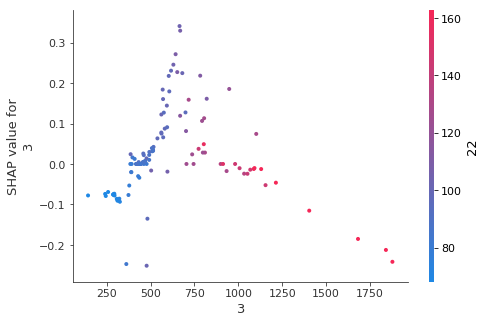

In [351]:
shap.dependence_plot(3, shap_values_original, X_valid.iloc[:,:])